Checking frequency stability for jack (accelerometer): False
Anomalies in jack (accelerometer): 17855


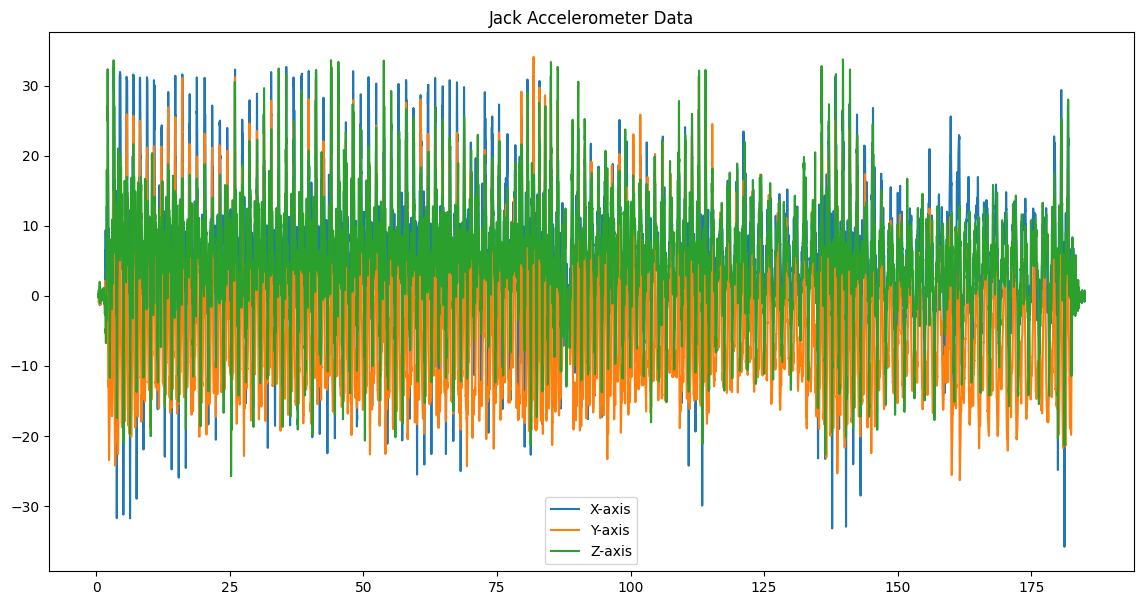

Checking frequency stability for jack (gyroscope): False
Anomalies in jack (gyroscope): 9216


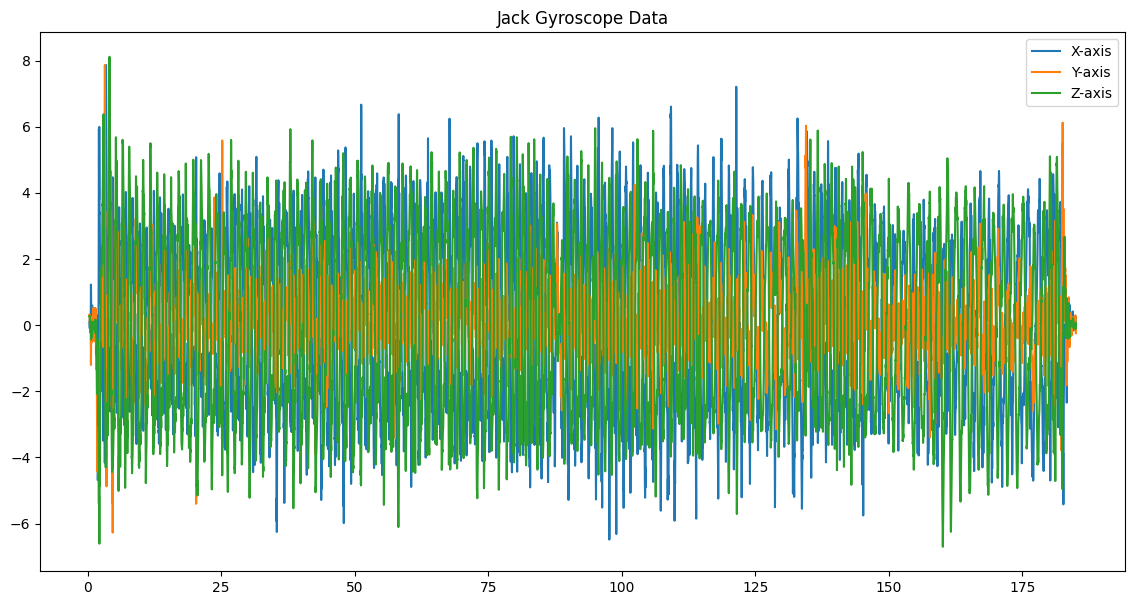

Checking frequency stability for pres (accelerometer): False
Anomalies in pres (accelerometer): 8417


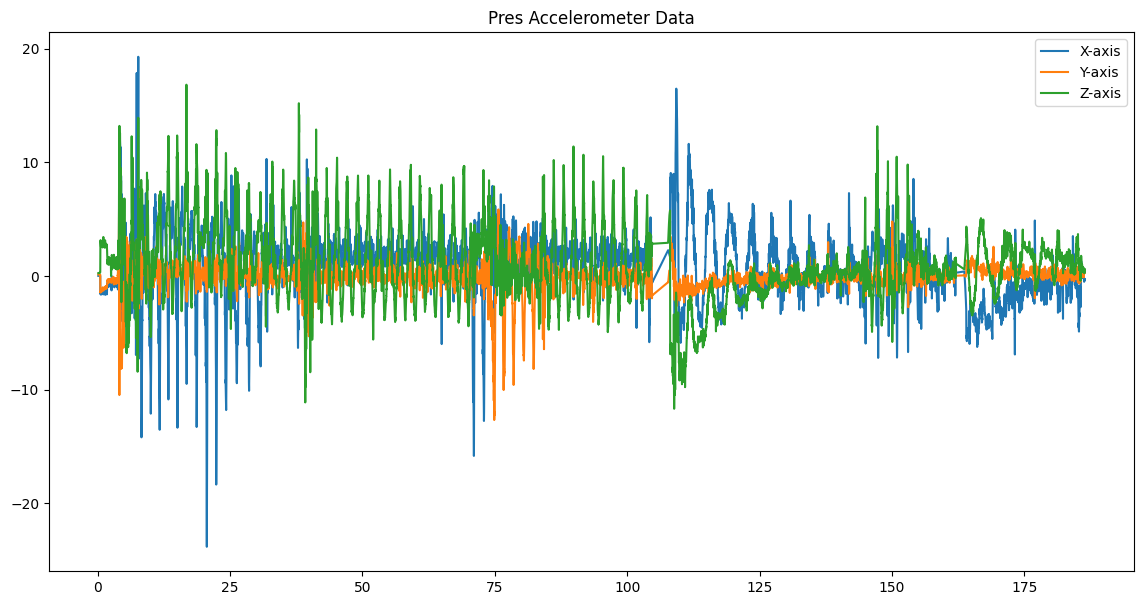

Checking frequency stability for pres (gyroscope): False
Anomalies in pres (gyroscope): 770


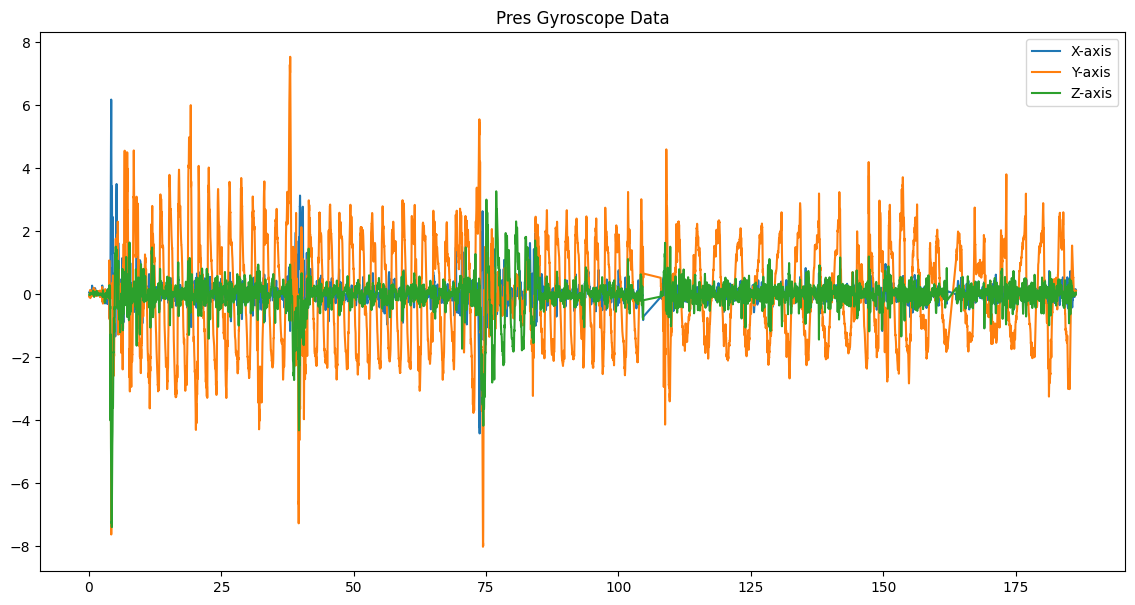

Checking frequency stability for run (accelerometer): False
Anomalies in run (accelerometer): 18642


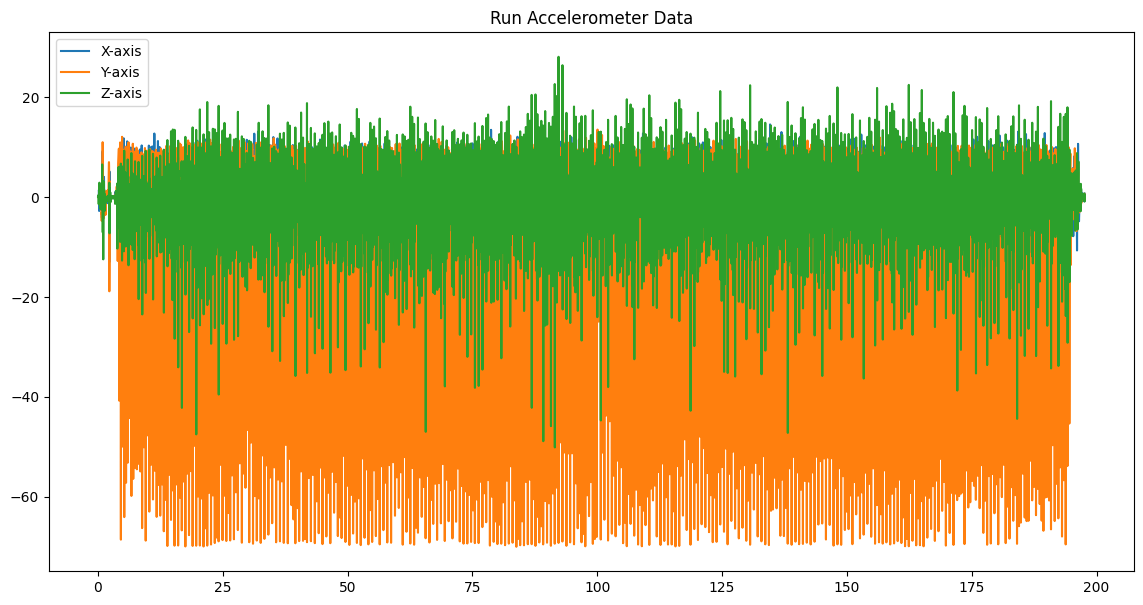

Checking frequency stability for run (gyroscope): False
Anomalies in run (gyroscope): 3715


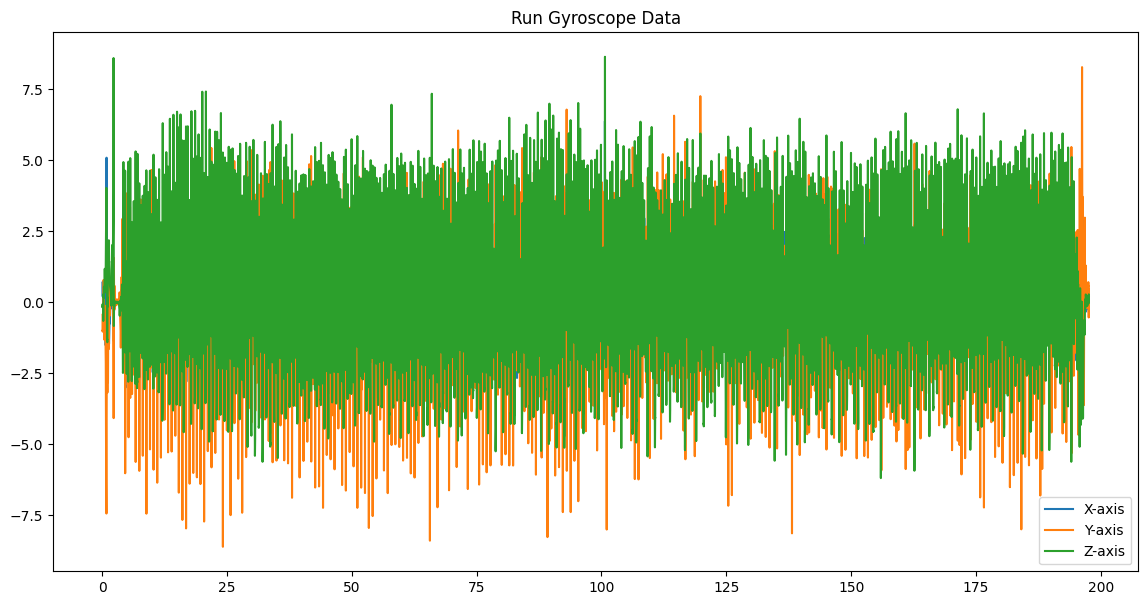

Accuracy: 0.9559082892416225


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import glob
import os

def load_all_data(folder_path):
    folder_path = os.path.abspath(folder_path)
    file_paths = glob.glob(os.path.join(folder_path, "*.csv"))
    if not file_paths:
        print(f"No CSV files found in {folder_path}")
        return {}
    
    data = {}
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        if len(parts) < 2:
            print(f"File {filename} does not match the expected naming convention.")
            continue
        activity, sensor_type = parts[0], parts[1].split('.')[0]
        key = f"{activity}_{sensor_type}"
        
        df = pd.read_csv(file_path)
        if df.empty:
            print(f"Warning: {file_path} is empty.")
        else:
            data[key] = df

    return data

def check_frequency(data, frequency=30):
    data['time_diff'] = data['seconds_elapsed'].diff()
    return np.allclose(data['time_diff'].dropna(), 1/frequency, atol=1e-2)

def detect_anomalies(data, threshold=3):
    return data[(np.abs(data[['x', 'y', 'z']]) > threshold).any(axis=1)]

def compute_window_statistics(window):
    return {
        'mean_x': window['x'].mean(),
        'std_x': window['x'].std(),
        'min_x': window['x'].min(),
        'max_x': window['x'].max(),
        'mean_y': window['y'].mean(),
        'std_y': window['y'].std(),
        'min_y': window['y'].min(),
        'max_y': window['y'].max(),
        'mean_z': window['z'].mean(),
        'std_z': window['z'].std(),
        'min_z': window['z'].min(),
        'max_z': window['z'].max(),
    }

def process_data(data, window_size=2, frequency=30):
    window_length = window_size * frequency
    windows = [data.iloc[i:i+window_length] for i in range(0, len(data), window_length) if len(data.iloc[i:i+window_length]) == window_length]
    stats = [compute_window_statistics(window) for window in windows]
    return pd.DataFrame(stats)

def plot_data(data, title):
    plt.figure(figsize=(14, 7))
    for col in ['x', 'y', 'z']:
        plt.plot(data['seconds_elapsed'], data[col], label=f'{col.capitalize()}-axis')
    plt.legend()
    plt.title(title)
    plt.show()

data = load_all_data('data_folder')
if not data:
    print("No data available for processing.")
else:
    all_stats = []
    for key, current_data in data.items():
        activity, sensor = key.split('_')
        
        is_stable = check_frequency(current_data)
        print(f'Checking frequency stability for {activity} ({sensor}): {is_stable}')
        
        anomalies = detect_anomalies(current_data)
        print(f'Anomalies in {activity} ({sensor}): {len(anomalies)}')
        
        plot_data(current_data, f'{activity.capitalize()} {sensor.capitalize()} Data')
        
        stats = process_data(current_data)
        if not stats.empty:
            stats['activity'] = activity
            stats['sensor'] = sensor
            all_stats.append(stats)
        else:
            print(f"No valid windows for {activity} ({sensor})")

    if all_stats:
        df_stats = pd.concat(all_stats, ignore_index=True)
        X = df_stats.drop(columns=['activity', 'sensor'])
        y = df_stats['activity']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy}')
    else:
        print("No data available for processing.")
